In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [7]:
# Load dataset
df = pd.read_csv('all_stocks_5yr.csv')

In [9]:
# Create 'ROI' column based on Open and Close prices
df['ROI'] = ((df['close'] - df['open']) / df['open']) * 100

In [11]:
# Convert date column to datetime and create new date-related features
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [12]:
# Drop the original date column
df = df.drop(columns=['date'])

In [15]:
# Drop rows with missing values in relevant columns
df.dropna(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)

In [17]:
# Add moving averages and volatility features
df['ma_7'] = df['close'].rolling(window=7).mean()
df['ma_21'] = df['close'].rolling(window=21).mean()
df['volatility'] = df['close'].rolling(window=7).std()

In [19]:
# Drop rows with NaN values created by moving averages/volatility calculations
df.dropna(inplace=True)

In [29]:
# Dataset Overview
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Basic statistics of the numerical features
print("\nStatistical Summary:")
print(df.describe())

Dataset Shape: (619009, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 619009 entries, 20 to 619039
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   open        619009 non-null  float64
 1   high        619009 non-null  float64
 2   low         619009 non-null  float64
 3   close       619009 non-null  float64
 4   volume      619009 non-null  int64  
 5   Name        619009 non-null  object 
 6   ROI         619009 non-null  float64
 7   year        619009 non-null  int32  
 8   month       619009 non-null  int32  
 9   day         619009 non-null  int32  
 10  ma_7        619009 non-null  float64
 11  ma_21       619009 non-null  float64
 12  volatility  619009 non-null  float64
 13  year_month  619009 non-null  object 
dtypes: float64(8), int32(3), int64(1), object(2)
memory usage: 63.8+ MB

Missing Values in Each Column:
open          0
high          0
low           0
close         0
volume   

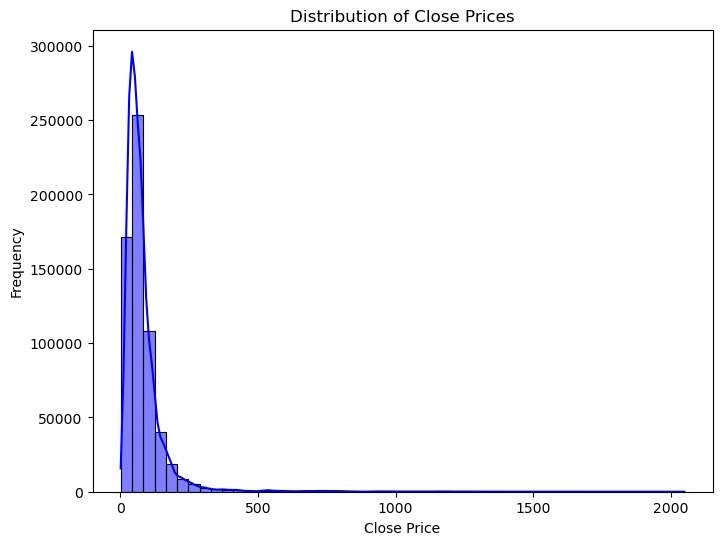

In [21]:
# Distribution of 'close' prices
plt.figure(figsize=(8, 6))
sns.histplot(df['close'], bins=50, kde=True, color='blue')
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

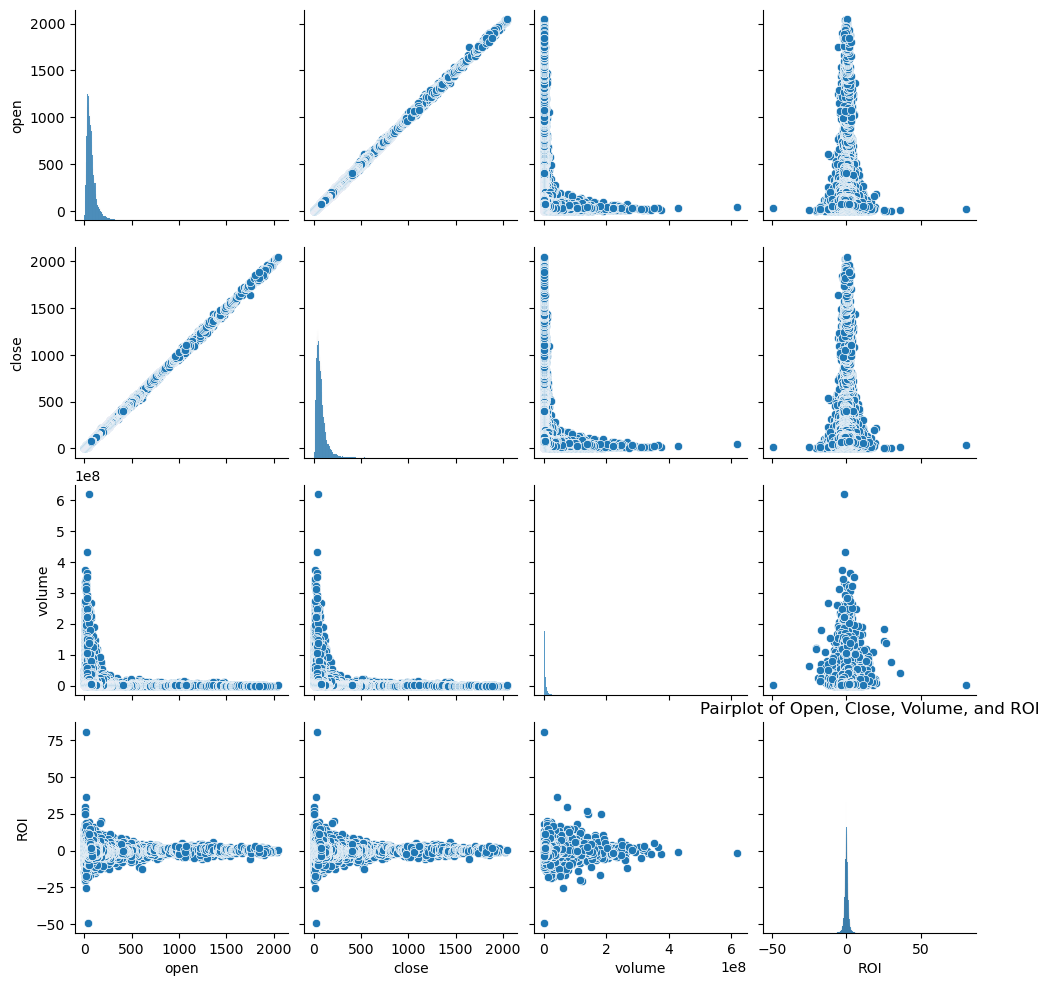

In [23]:
# Pairplot for key features
sns.pairplot(df[['open', 'close', 'volume', 'ROI']])
plt.title('Pairplot of Open, Close, Volume, and ROI')
plt.show()

C:\Users\akala\AppData\Local\Temp\ipykernel_36768\2540778019.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='year_month', y='close', ci=None)


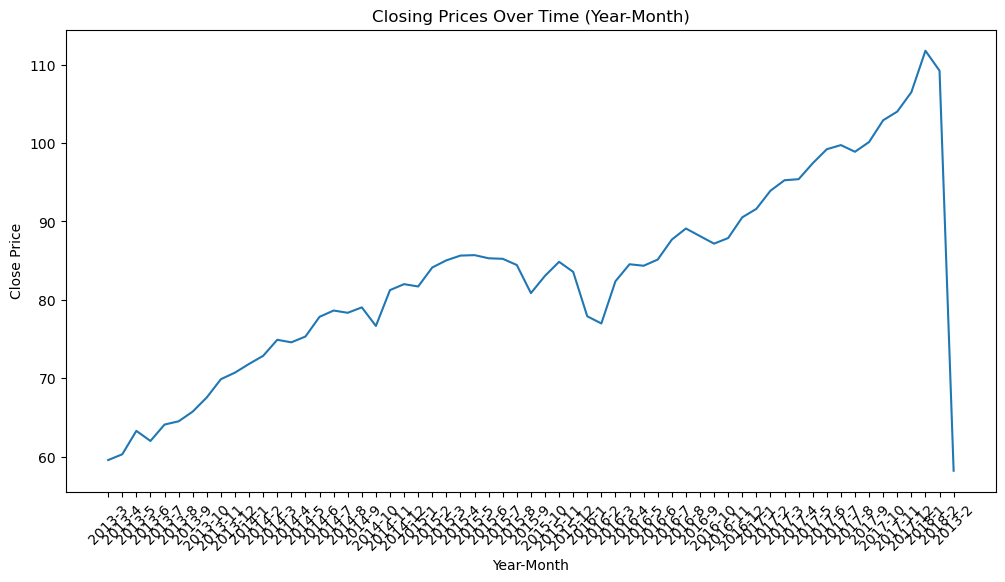

In [25]:
# Time series plot of stock closing price by year and month
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year_month', y='close', ci=None)
plt.title('Closing Prices Over Time (Year-Month)')
plt.xlabel('Year-Month')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()

In [83]:
# Define target variable (y) and features (X)
X = df[['open', 'high', 'low', 'close', 'volume', 'year', 'month', 'day', 'ma_7', 'ma_21', 'volatility']]
y = df[['ROI']]

In [85]:
# Split data into training and testing sets for regression (ROI percentage)
X_train, X_test, y_train_roi, y_test_roi = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train_scaled)
X_poly_test = poly.transform(X_test_scaled)

In [93]:
# Train Linear Regression model with polynomial features
linear_model = LinearRegression()
linear_model.fit(X_poly_train, y_train_roi)

LinearRegression()

In [95]:
# Predict ROI percentage using the polynomial regression model
y_pred_linear = linear_model.predict(X_poly_test)

In [97]:
# Evaluate the Linear Regression model with polynomial features
mse_linear = mean_squared_error(y_test_roi, y_pred_linear)
r2_linear = r2_score(y_test_roi, y_pred_linear)

In [99]:
print(f"Mean Squared Error for Linear Regression (Polynomial) ROI Prediction: {mse_linear}")
print(f"R^2 Score for Linear Regression (Polynomial) ROI Prediction: {r2_linear}")

Mean Squared Error for Linear Regression (Polynomial) ROI Prediction: 0.6906406772202274
R^2 Score for Linear Regression (Polynomial) ROI Prediction: 0.61874064468985


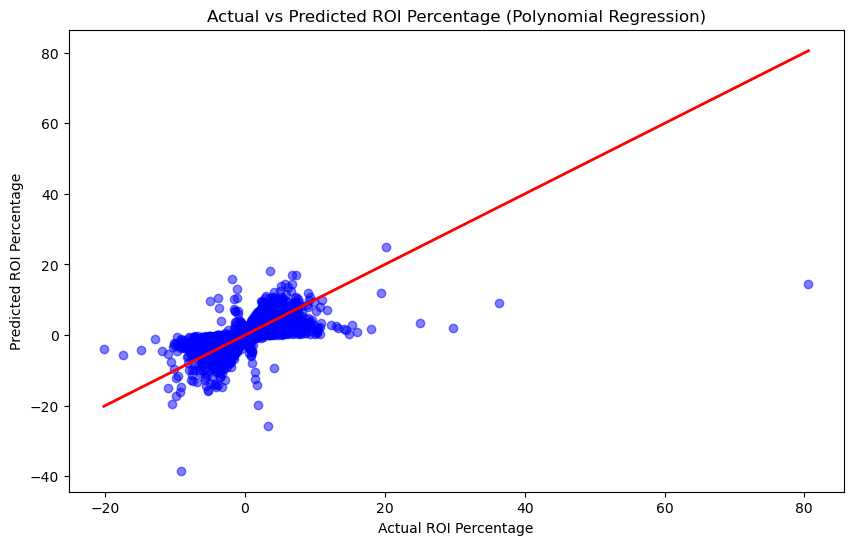

In [101]:
# Visualize the predicted ROI vs actual ROI
plt.figure(figsize=(10,6))
plt.scatter(y_test_roi, y_pred_linear, color='blue', alpha=0.5)
plt.plot([y_test_roi.min(), y_test_roi.max()], [y_test_roi.min(), y_test_roi.max()], color='red', lw=2)
plt.xlabel('Actual ROI Percentage')
plt.ylabel('Predicted ROI Percentage')
plt.title('Actual vs Predicted ROI Percentage (Polynomial Regression)')
plt.show()

In [103]:
# Create a binary 'Profit/Loss' column
df['Profit_Loss'] = np.where(df['ROI'] > 0, 1, 0)
X_class = df[['open', 'high', 'low', 'close', 'volume', 'year', 'month', 'day', 'ma_7', 'ma_21', 'volatility']]
y_class = df['Profit_Loss']

In [105]:
# Split data into training and test sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

In [107]:
# Scale the features for classification
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_test_class_scaled = scaler_class.transform(X_test_class)

In [109]:
# Train a simple Logistic Regression model for profit/loss prediction
classification_model = LogisticRegression()
classification_model.fit(X_train_class_scaled, y_train_class)

LogisticRegression()

In [111]:
# Predict profit/loss on the test set
y_pred_class = classification_model.predict(X_test_class_scaled)

In [113]:
# Calculate accuracy
accuracy_class = accuracy_score(y_test_class, y_pred_class)
print(f"Accuracy for Profit/Loss Classification: {accuracy_class}")

Accuracy for Profit/Loss Classification: 0.9788210206620248


In [115]:
# Confusion matrix for profit/loss classification
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

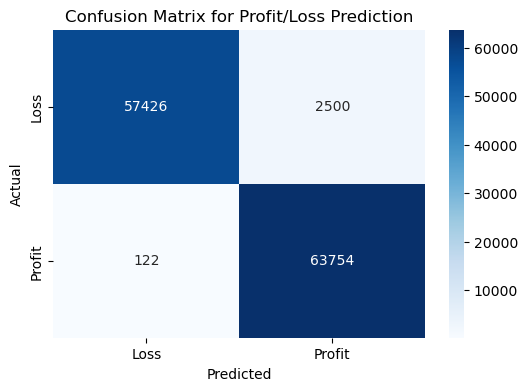

In [117]:
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Loss', 'Profit'], yticklabels=['Loss', 'Profit'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Profit/Loss Prediction')
plt.show()

In [119]:
# Feature Importance for Polynomial Regression
coefs = linear_model.coef_
feature_names = poly.get_feature_names_out(X_train.columns)
important_features = np.abs(coefs).mean(axis=0)

In [121]:
# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': important_features
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
         Feature  Importance
3          close   93.162254
0           open   90.270318
13      open low   80.476666
12     open high   77.233874
24    high close   70.924671
..           ...         ...
49      volume^2    0.000962
56        year^2    0.000592
7            day    0.000412
76  volatility^2    0.000309
57    year month    0.000250

[77 rows x 2 columns]


In [123]:
# Cross-Validation for Polynomial Regression
cv_scores = cross_val_score(linear_model, poly.transform(X_train_scaled), y_train_roi, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = -np.mean(cv_scores)  # Convert negative MSE to positive
print(f"Mean Cross-Validation MSE: {mean_cv_score}")

Mean Cross-Validation MSE: 0.6465933057921948


In [124]:
cv_scores_r2 = cross_val_score(linear_model, poly.transform(X_train_scaled), y_train_roi, cv=5, scoring='r2')
mean_cv_r2 = np.mean(cv_scores_r2)
print(f"Mean Cross-Validation R² Score: {mean_cv_r2}")

Mean Cross-Validation R² Score: 0.6290135515894606


In [129]:
import pickle

# Save the Polynomial Regression model (with polynomial features)
with open('linear_regression_poly_model.pkl', 'wb') as file:
    pickle.dump(linear_model, file)

In [131]:
# Save the Polynomial Features transformer
with open('polynomial_features.pkl', 'wb') as file:
    pickle.dump(poly, file)

In [133]:
# Save the Logistic Regression classification model
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(classification_model, file)

In [135]:
# Save the Standard Scaler used for scaling features
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [137]:
# Save the Standard Scaler used for classification
with open('scaler_class.pkl', 'wb') as file:
    pickle.dump(scaler_class, file)